Emphasize:
- Problem Solving Skills
- Exploratory Data Analysis
- Understand Problem domain

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, BayesianRidge, LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsRegressor

import dtw
from utils import (WMAE, hold_out_residual,
                   resid_plot,
                   cross_validate)

df = pd.read_csv('./data/winton/train.csv', index_col='Id')

Error function for Evaluation
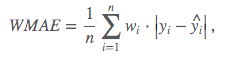

# Strategy

- Data Cleaning
    - Deal with NaNs
    - Mask data
- EDA
    - Naive Model
        - Look at residuals
- Setup Cross Validating (will figure this out on Naive Model)
- Model Improvements
    - Feature Selection and Engineering
- Potential future improvements
    - DTW with KNN (k=1?)
        - [https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb]
        - Or possibly: http://alexminnaar.com/time-series-classification-and-clustering-with-python.html
    - Clustering
        - kmeans/GMM on features
        - Hierarchical clustering on DTW distances
    - Clustering and stacking based on membership?
    - Make a somewhat sequential model where D+2 is calculated from D+1

In [3]:
mask_exog_return_days = ['Ret_MinusTwo', 'Ret_MinusOne']
mask_endog_return_days = ['Ret_PlusOne', 'Ret_PlusTwo']

mask_exog_feature = [i for i in df.columns if 'Feature_' in i]
mask_exog_return = [i for i in df.columns 
                    if 'Ret_' in i
                    and i not in mask_exog_return_days
                    and i not in mask_endog_return_days]
mask_exog_return = [i for i in mask_exog_return if int(i.split('_')[1]) <= 120]
mask_exog = mask_exog_return + mask_exog_feature
mask_exog = mask_exog_return_days + mask_exog

mask_endog_return = [i for i in df.columns 
                    if 'Ret_' in i
                    and i not in mask_exog_return_days
                    and i not in mask_endog_return_days]
mask_endog_return = [i for i in mask_endog_return if int(i.split('_')[1]) > 120]
mask_endog = mask_endog_return + mask_endog_return_days

mask_weights = ['Weight_Intraday', 'Weight_Daily']

### Data Cleaning

In [4]:
df.dtypes

Feature_1          float64
Feature_2          float64
Feature_3          float64
Feature_4          float64
Feature_5          float64
Feature_6          float64
Feature_7            int64
Feature_8          float64
Feature_9          float64
Feature_10         float64
Feature_11         float64
Feature_12         float64
Feature_13         float64
Feature_14         float64
Feature_15         float64
Feature_16         float64
Feature_17         float64
Feature_18         float64
Feature_19         float64
Feature_20         float64
Feature_21         float64
Feature_22         float64
Feature_23         float64
Feature_24         float64
Feature_25         float64
Ret_MinusTwo       float64
Ret_MinusOne       float64
Ret_2              float64
Ret_3              float64
Ret_4              float64
                    ...   
Ret_155            float64
Ret_156            float64
Ret_157            float64
Ret_158            float64
Ret_159            float64
Ret_160            float64
R

Not sure what 'Feature_7' is. Maybe it's a population? Will keep this in mind throughout. 

In [5]:
df['Feature_7']

Id
1        75751
2        17369
3         8277
4        22508
5        22423
6        24099
7        39351
8        92214
9        18418
10       47637
11       51499
12       79888
13       63267
14       35023
15       76131
16       69564
17       94022
18       16080
19       14259
20       65146
21       47683
22       35266
23       49660
24       57773
25       34161
26       64351
27       19660
28       94975
29       99483
30       40712
         ...  
39971    54939
39972    76736
39973    62179
39974    39562
39975    34124
39976    60280
39977    99075
39978    48365
39979    39069
39980    23153
39981    44670
39982    34324
39983    39848
39984     1344
39985    29262
39986    97667
39987    34425
39988    27661
39989    43321
39990    33304
39991    62488
39992    28859
39993    82639
39994    35409
39995    64603
39996    23729
39997    56222
39998     7024
39999    27376
40000     4141
Name: Feature_7, Length: 40000, dtype: int64

### Deal with NaNs

##### Most rows have nulls

In [6]:
df.isnull().values.any(axis=1).mean()

0.976775

In [7]:
mask_ignore_feat = list(filter(lambda x: 'Feat' not in x, mask_exog))

##### Half of the rows that have a null 'anywhere' are due to features missing. Let's ignore them for the naive model. (for now)

In [8]:
df[mask_ignore_feat]\
    .isnull().values.any(axis=1).mean()

0.44025

##### non of the endog return days are missing this is nice. 

In [9]:
df[mask_endog_return_days].isnull().values.any(axis=1).mean()

0.0

##### None of the endog minutes are missing

In [10]:
df[mask_endog].isnull().values.any(axis=1).mean()

0.0

##### none of the exogenous days are missing (D-2 and D-1)

In [11]:
df[mask_exog_return_days].isnull().mean()

Ret_MinusTwo    0.0
Ret_MinusOne    0.0
dtype: float64

#### For the missing exogenous minute time data how do we want to handle NaNs?

For exogenous minutes it looks like there's never more than 3.5% of the data missing. Since this is a pretty small I will fillna's with linearly interpolated data. I can come back to this later. 

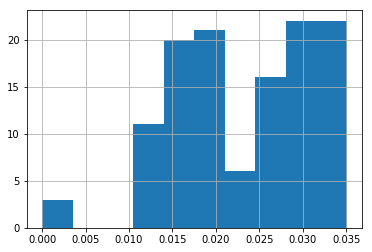

In [12]:
df[mask_ignore_feat].isnull().mean().hist()

##### Interpolate missing exogenous minutes

In [13]:
def interpolate_time(df):
    df[mask_ignore_feat] = df[mask_ignore_feat].T.interpolate().T
    return df

#### Before and after interpolation

In [14]:
df[mask_ignore_feat].isnull().values.any(axis=1).mean()

0.44025

##### 0 nulls are left

In [15]:
df = interpolate_time(df)

In [16]:
df[mask_ignore_feat].isnull().values.any(axis=1).mean()

0.0

### Features

In [40]:
X = df[mask_exog]
Y = df[mask_endog]
w = df[mask_weights]

X['intra_return_mean_x'] = X[mask_exog_return].T.mean()
X['intra_return_std'] = X[mask_exog_return].T.std()
X['intra_return_max'] = X[mask_exog_return].T.max()
X['intra_return_min'] = X[mask_exog_return].T.min()
X['Ret_Diff_D2_D1'] = X['Ret_MinusOne'] - X['Ret_MinusTwo']
X['Ret_Diff_D1_D0'] = X['intra_return_mean_x'] - X['Ret_MinusOne']
X['Ret_Diff_partial_D0_D2'] = X['intra_return_mean_x'] - X['Ret_MinusTwo']



Y['intra_return_mean_y'] = Y[mask_endog_return].T.mean()

#### WMAE 
Adjusting Weights. I've decided to give up on predicting T+60 minutes. It's quite challenging and the data is noisy enough as it is. If I have time later I'll come back to it. 

w_1 weights have the intraday multiplied by 60 since we reduced from 60 features down to one aggregate feature that captures information about . Since the weight would have been applied to each of the intraday dependent variables (T-121 to T-180) it is appropriate to multiply 

In [48]:
w_1 = pd.concat([w['Weight_Intraday'] * 60, w['Weight_Daily'], w['Weight_Daily']], axis=1)

mask_x_simple = ["intra_return_mean_x",
                 "intra_return_std",
                 "intra_return_max",
                 "intra_return_min",
                 "Ret_Diff_D2_D1",
                 "Ret_Diff_D1_D0",
                 "Ret_Diff_partial_D0_D2"]
mask_y_simple = ['intra_return_mean_y'] + mask_endog_return_days
Y_simple = Y[mask_y_simple]
X_simple = X[mask_x_simple + mask_exog_return_days]

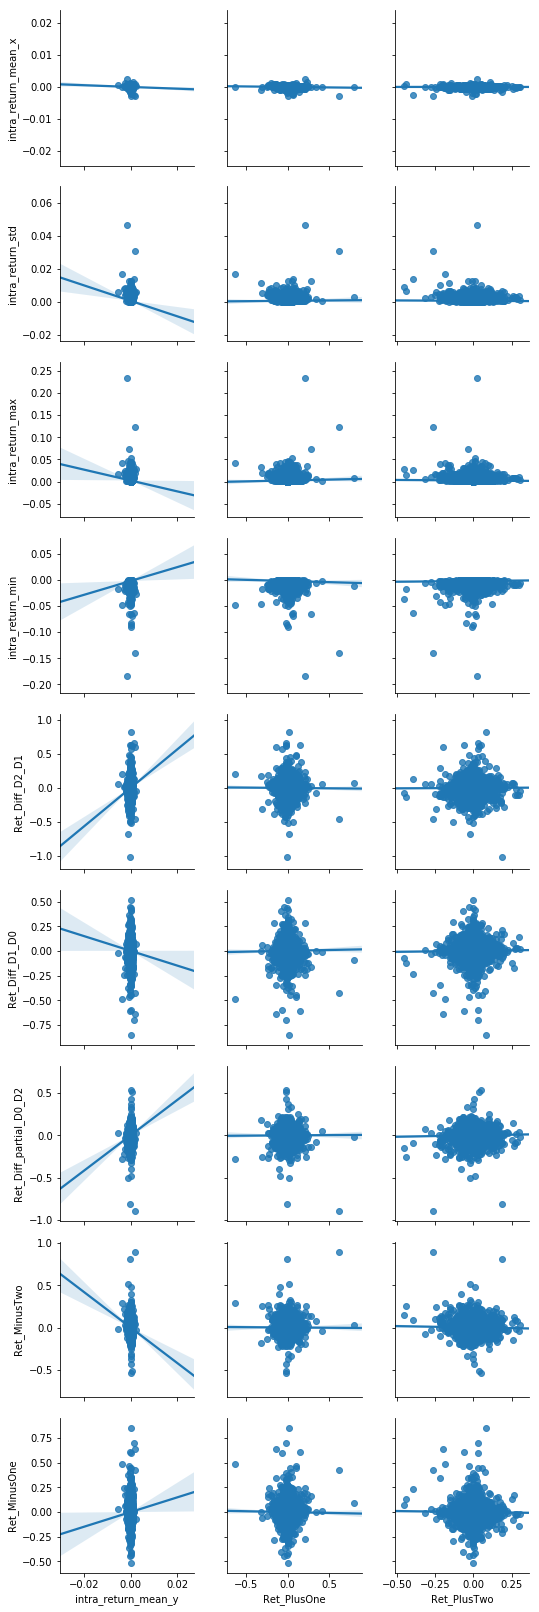

In [30]:
# sns.pairplot(pd.concat([X_simple, Y_simple], axis=1), kind='reg',
#              y_vars=X_simple.columns,
#              x_vars=Y_simple.columns)

# Model

In [19]:
def cross_val_multiple(model, x, y, w):
    for i in range(y.shape[1]):
        cross_validate(model, x, y[:, i], w[:, i])

In [20]:
model = Pipeline(steps=[
    ('minmax_scaler', MinMaxScaler()),
    ('model1', LinearRegression())
])

cross_val_multiple(model, X_simple.values, Y_simple.values, w_1.values)

Cross Val Score: 7073.164236575453
 Cross Val Std: 72.27482446345331
 K: 3
Cross Val Score: 28410.610439421067
 Cross Val Std: 291.6735761962109
 K: 3
Cross Val Score: 27464.299957326915
 Cross Val Std: 338.173650108166
 K: 3


In [21]:
from utils import hold_out_residual

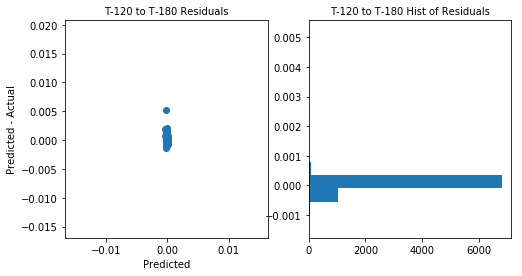

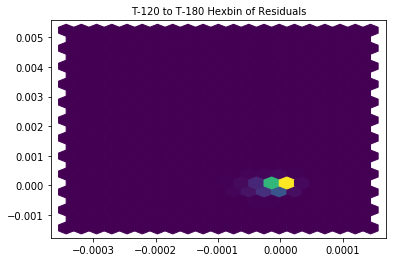

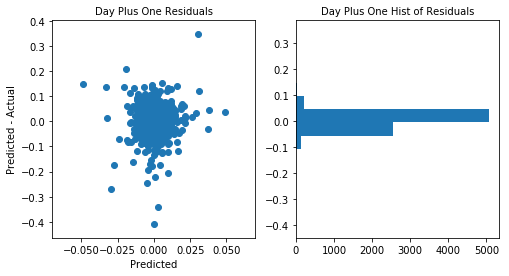

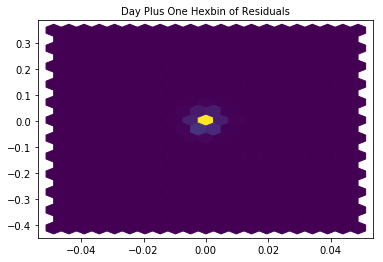

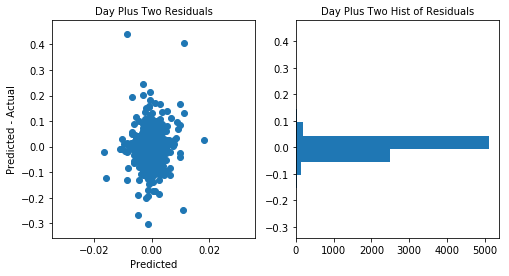

21296.547255805734

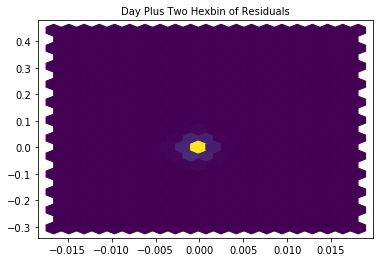

In [22]:
hold_out_residual(model, X_simple, Y_simple, w_1,
                  endog_titles=['T-120 to T-180', 'Day Plus One', 'Day Plus Two'])

# Thoughts

These features aren't providing any more signal. Perhaps if we include the feature columns

# Model # 2

Some of the 25 features have nulls.

Getting rid of all the features that contain nulls will lose over 50% of the data.

In [83]:
w_1 = pd.concat([w['Weight_Intraday'] * 60, w['Weight_Daily'], w['Weight_Daily']], axis=1)
features_mask = [feat for feat in X.columns if 'Feat' in feat
                 and feat not in [
                     'Feature_1', 'Feature_2', 'Feature_4', 'Feature_9', 'Feature_10',
                     'Feature_15', 'Feature_20'
                 ]]
X_wfeatures = X[["intra_return_mean_x",
                "intra_return_std",
                "intra_return_max",
                "intra_return_min",
                "Ret_Diff_D2_D1",
                "Ret_Diff_D1_D0",
                "Ret_Diff_partial_D0_D2"] + features_mask]
X_wfeatures = X_wfeatures.dropna(how='any')
Y_wfeatures = Y_simple.loc[X_wfeatures.index]
w_wfeatures = w_1.loc[X_wfeatures.index]

In [84]:
model = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])
for i in range(3):
    cross_validate(model, X_wfeatures.values, Y_wfeatures.values[:, i],
                   w_wfeatures.values[:, i])

Cross Val Score: 7064.039604331117
 Cross Val Std: 84.14157242558099
 K: 3
Cross Val Score: 28415.27745348934
 Cross Val Std: 180.0209212266642
 K: 3
Cross Val Score: 27585.239317642856
 Cross Val Std: 197.24253073077045
 K: 3


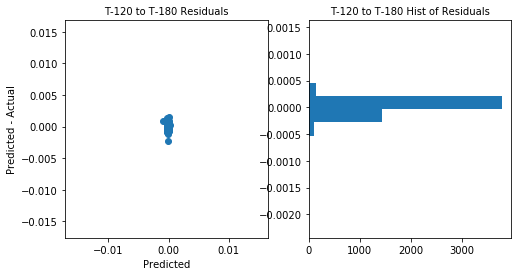

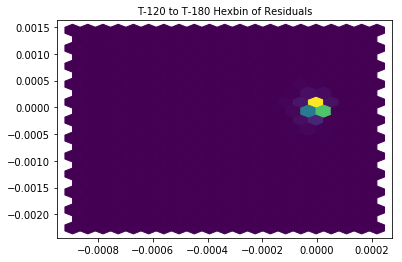

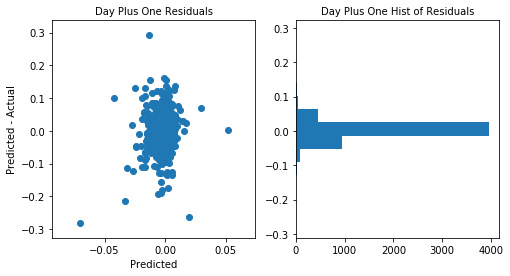

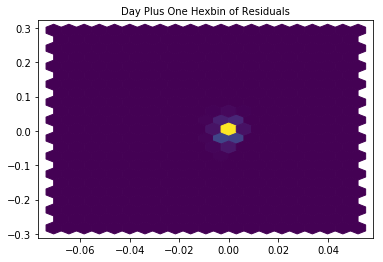

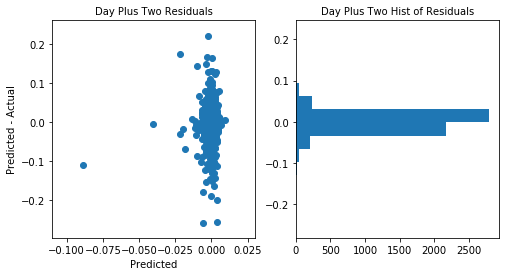

20674.30129262135

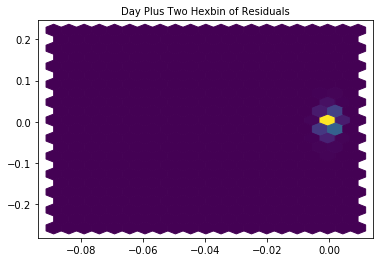

In [86]:
hold_out_residual(model, X_wfeatures, Y_wfeatures, w_wfeatures,
                  endog_titles=['T-120 to T-180', 'Day Plus One', 'Day Plus Two'])

### Thoughts

Ok Let's look at interaction terms

# Model # 3 feature selection

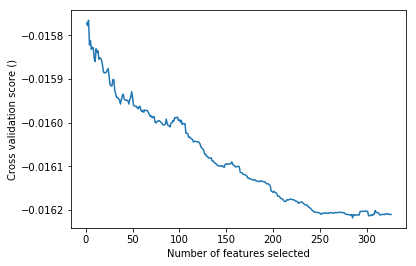

Feature Ranking is: [252  35  54  33  36 128  88  82 130 170 136 308 127 152 271 155 114 113
 174 259 181 133 198 230 261 207   1   1   3   6  10  58  18  74  19 208
   5  17  90  66  12  15  14  22  13  21  24  27  28  23   2   1  61   9
   7  41  72  64 290  25  63  87 151  29  30  51  55  37  40 100  77  57
  39   4  42  11  80  43  73  46 302  26  68  67  70  53  69  52  50  59
  44  75 104  60  56  20  16   8  84  86  45 305  31  65  76  71  32  79
  49  48  38  47 101  78  62 140  85 122 164 163 124 177  93 121 172 160
 107 109 118  98 111 132 203 146 145 116  34  92 129  96 176  94  91 147
 161  89 110 119 300 112 125 143 178 165 117 102 162 105 175  81 103 166
 139  83  95 106 108  97 138 123 120 180  99 240 210 311 158 294 209 213
 201 131 216 277 263 243 291 229 265 168 304 319 258 241 272 293 283 171
 287 286 266 239 284 282 267 296 324 159 276 193 227 262 134 211 212 187
 285 215 244 248 200 315 310 317 318 309 307 321 313 312 314 323 320 316
 322 257 137 270 144 126 184 25

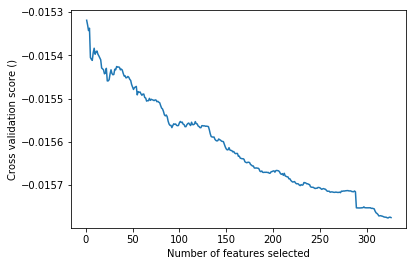

Feature Ranking is: [271   9  29  35  36  77  76  64 129 240 236 309 111 130 153 219 107 104
 159 158 127 176 141 289 205 138   1  12   3   7   6   2  22 119  70 202
  18  20  21  73  27  16  78  17  15  23  19  24  34  28   5   4  13  48
  10 149 204  49 269  63  33  39  80  68  30  54  74  42  32  53 134  94
  67   8  14  25  47  46  83  51 307  62  55  59  82  66  31  44  41  90
  52  85  72  57  86  98  26  11  60  84  56 298 105  61  38  81  69  37
  45  43  40  50  96  71  58  75 100  79  99 167 121 162 102 136 122 152
 110 103 258  89 113 120 109 124 114 123  91 108 207  93 163 143 135 147
 168 181 200 247 201  87  92 190 125 133 101 116 148 140 161 250 117 256
 206  95  65 231 115 118 132  88  97 160 146 243 218 322 172 296 198 278
 150 128 241 182 216 217 279 260 284 209 237 323 211 244 228 294 246 268
 239 305 282 238 266 264 290 249 315 297 259 277 253 214 215 235 287 281
 295 276 308 254 213 311 316 312 320 313 319 326 321 310 314 317 324 318
 325 155 186 169 139 112 156 15

In [94]:
from sklearn.feature_selection import RFECV
poly = PolynomialFeatures(interaction_only=True)
poly.fit_transform(X_wfeatures)
chosen_features = []
for i in range(2):
    fs = RFECV(LinearRegression(n_jobs=-1), scoring='neg_mean_absolute_error')

    fs.fit(poly.transform(X_wfeatures.values), Y_wfeatures.values[:, i + 1])

    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score ()")
    plt.plot(range(1, len(fs.grid_scores_) + 1), fs.grid_scores_)
    plt.show()
    print("Feature Ranking is: {}".format(fs.ranking_))
    chosen_features.append(fs.ranking_)

In [95]:
X_create_features = poly.transform(X_wfeatures)
X_chosen_1 = X_create_features[:, (chosen_features[0] == 1)]
X_chosen_2 = X_create_features[:, (chosen_features[1] == 1)]

### Choesen Features

##### For model 1 which is responsible for Day + 1

In [109]:
[poly.get_feature_names()[i] for i in np.argwhere(chosen_features[0] == 1).ravel()]

['x0 x1', 'x0 x2', 'x1 x3']

In [110]:
X_wfeatures.head()

,intra_return_mean_x,intra_return_std,intra_return_max,intra_return_min,Ret_Diff_D2_D1,Ret_Diff_D1_D0,Ret_Diff_partial_D0_D2,Feature_3,Feature_5,Feature_6,...,Feature_14,Feature_16,Feature_17,Feature_18,Feature_19,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25
Id,,,,,,,,,,,,,,,,,,,,,
5,-0.000019,0.000832,0.002431,-0.002428,0.029289,-0.011084,0.018205,2.765531,7.0,4.866985,...,0.842102,1.0,6.317498,-3.208872,-1.102189,3.381040,1.732708,1.965189,-5.993092,3.219820
6,0.000145,0.000777,0.002801,-0.002751,-0.007334,-0.006994,-0.014328,-0.680515,1.0,0.227034,...,1.607182,1.0,-0.587538,0.230375,-0.897600,0.111960,1.670980,0.364626,1.039643,-0.404685
7,0.000050,0.000258,0.000719,-0.000575,0.009494,-0.006551,0.002943,-0.227021,7.0,-0.095007,...,1.829130,1.0,-0.140953,0.016076,-0.966690,-0.186534,1.080087,0.799836,-0.753148,-0.440274
8,-0.000025,0.000432,0.001236,-0.001504,0.001569,-0.006181,-0.004612,0.157344,8.0,-0.177333,...,1.489166,1.0,-0.788162,0.951173,-1.896213,0.264332,0.014091,1.071300,-2.083937,-0.706392
10,0.000053,0.001486,0.004930,-0.003707,-0.002046,-0.043478,-0.045524,0.813783,7.0,0.021982,...,1.241724,1.0,-0.296651,0.310053,-0.673504,0.015727,-2.443845,1.088876,-0.799818,-0.847132


##### For model 2 which was responsible for Day + 2

In [111]:
[poly.get_feature_names()[i] for i in np.argwhere(chosen_features[1] == 1).ravel()]

['x0 x1']

Intra return mean combined with intra return std were the best features to use and result in the best score. 

So features chose were combinations of:
Intra Mean, Intra Std
Intra Mean, Intra Max
Intra return std, Intra_return Min



In [113]:
model_1 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])

model_2 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])
cross_validate(model, X_wfeatures.values,
               Y_wfeatures.values[:, 0], w_wfeatures.values[:, 0])
cross_validate(model_1, X_chosen_1,
               Y_wfeatures.values[:, 1], w_wfeatures.values[:, 1])
cross_validate(model_2, X_chosen_2,
               Y_wfeatures.values[:, 2], w_wfeatures.values[:, 2])

Cross Val Score: 7064.039604331117
 Cross Val Std: 84.14157242558099
 K: 3
Cross Val Score: 28454.380936907026
 Cross Val Std: 216.3392320238094
 K: 3
Cross Val Score: 27446.48859573812
 Cross Val Std: 234.35653502245472
 K: 3


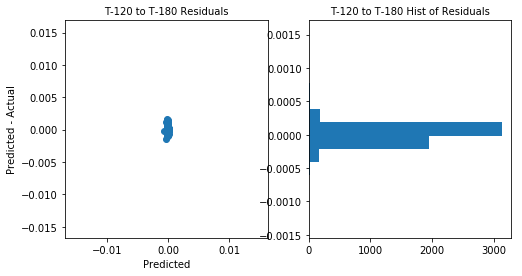

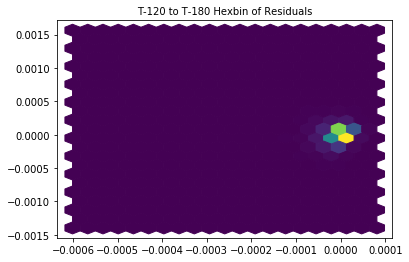

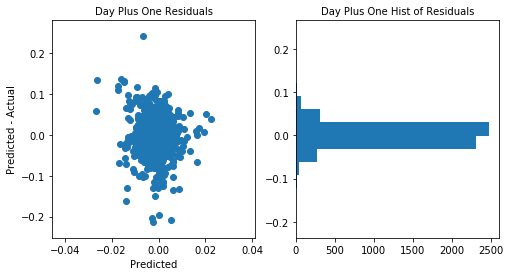

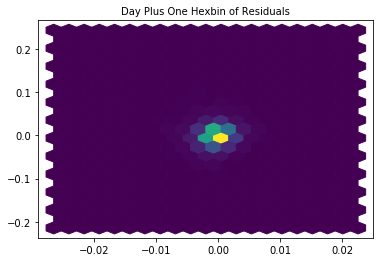

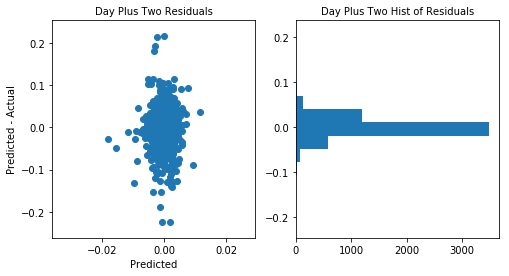

1.2737768085970301e-05

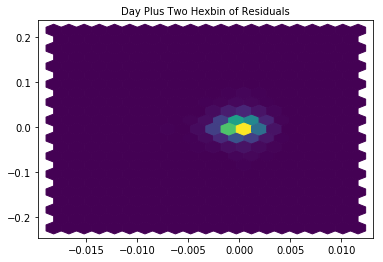

In [115]:
hold_out_residual(model_1, X_wfeatures, Y_wfeatures, Y_wfeatures,
                  endog_titles=['T-120 to T-180', 'Day Plus One', 'Day Plus Two'])

# Model # 4 Random Forest

In [117]:
from sklearn.ensemble import RandomForestRegressor

In [123]:
model_1 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('model', RandomForestRegressor(criterion='mae', n_jobs=-1))
])

model_2 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('model', RandomForestRegressor(criterion='mae', n_jobs=-1))
])
# cross_validate(model, X_wfeatures.values,
#                Y_wfeatures.values[:, 0], w_wfeatures.values[:, 0])
cross_validate(model_1, X_wfeatures.values,
               Y_wfeatures.values[:, 1], w_wfeatures.values[:, 1])
cross_validate(model_2, X_wfeatures.values,
               Y_wfeatures.values[:, 2], w_wfeatures.values[:, 2])

Cross Val Score: 28977.59433853727
 Cross Val Std: 545.4975230980252
 K: 3


KeyboardInterrupt: 

Stopped the model short.  Took 15 minutes to run. No sense waiting more time when I know I'm not even in the same state nevermind the right ball park. 

In [124]:
hold_out_residual(model_1, X_wfeatures, Y_wfeatures, w_wfeatures,
                  endog_titles=['T-120 to T-180', 'Day Plus One', 'Day Plus Two'])

KeyboardInterrupt: 

In [ ]:
hold_out_residual(model_2, X_wfeatures, Y_wfeatures, w_wfeatures,
                  endog_titles=['T-120 to T-180', 'Day Plus One', 'Day Plus Two'])

# Throws hands in the air. 


I don't understand what I'm missing. 

This project definitely made me review my feature selection knowledge. 

There was definitely some improvement just using LinearRegression instead of RANSAC like I was using in the other notebook. 

There was marginal improvement with PolyNomial Features under Model 3 with Recursive Feature Selection.  This was sort of a last ditch effort just before throwing it all into a random forest.

I'm surprised KNN didn't get me into a better situation.  

If I had more time, I would familiarize myself with LSTM's and try them out on this problem. 

### DTW (dynamic time warping) and Hierarchical clustering to turn the Ret_T features into perhaps useful feature.
inspiration from: https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping


##### This was too slow would have taken days. :-/

In [42]:
ts = X[mask_exog_return]

In [43]:
ts

,Ret_2,Ret_3,Ret_4,Ret_5,Ret_6,Ret_7,Ret_8,Ret_9,Ret_10,Ret_11,...,Ret_111,Ret_112,Ret_113,Ret_114,Ret_115,Ret_116,Ret_117,Ret_118,Ret_119,Ret_120
Id,,,,,,,,,,,,,,,,,,,,,
1,2.954272e-06,-0.000734,-0.000738,-0.000007,0.000423,4.377022e-04,-0.000076,6.446240e-04,-0.000006,0.000006,...,0.000697,7.000474e-04,-8.431473e-04,2.679678e-04,-4.152112e-04,-0.001133,4.431501e-06,-0.000137,-0.000009,1.340780e-04
2,-4.871459e-04,0.000475,0.000002,-0.000002,-0.000523,-2.551758e-04,-0.000008,4.843796e-05,-0.000312,-0.000742,...,-0.000010,2.494024e-04,4.918272e-04,-2.201786e-05,4.606377e-05,-0.000294,-3.663952e-04,-0.000125,-0.000007,2.558108e-04
3,-7.822703e-04,-0.000402,0.000807,0.000400,0.000656,-1.176960e-03,0.001198,6.100221e-04,-0.001031,0.000647,...,0.000250,-1.379924e-04,-2.660449e-04,7.859514e-04,1.702236e-03,-0.000271,-5.304943e-04,-0.000666,-0.000270,-3.718829e-04
4,2.773425e-04,-0.000088,-0.000199,-0.000301,0.000711,-4.311588e-04,-0.000144,3.404036e-04,-0.000639,0.000420,...,-0.000571,2.880709e-04,5.672140e-06,1.478455e-04,-2.596976e-04,0.000387,-4.352181e-04,-0.000689,0.000153,2.220483e-04
5,-1.232316e-03,0.000002,-0.001205,-0.000021,0.000005,6.233481e-04,-0.001843,4.518627e-06,0.001226,0.001213,...,-0.000014,1.209899e-03,1.112321e-05,-4.547193e-06,-1.091879e-05,0.000003,-1.229378e-03,-0.000003,0.001208,-4.473375e-07
6,-5.736361e-06,0.000914,-0.000247,0.000928,0.000350,-2.272352e-04,-0.000002,-5.588487e-07,0.000232,-0.000215,...,0.000921,1.154186e-03,-2.487525e-04,-2.234846e-04,-4.597824e-04,-0.000684,4.627458e-04,0.000444,0.002801,-9.368129e-04
7,3.110509e-07,-0.000027,-0.000546,-0.000096,0.000020,-2.733977e-04,0.000245,2.992528e-04,-0.000300,-0.000099,...,-0.000341,1.576190e-04,1.606346e-04,-5.495968e-06,4.795455e-04,0.000635,6.481310e-04,-0.000346,0.000324,3.230829e-04
8,1.761826e-04,0.000558,-0.000007,0.000005,-0.000016,-2.467405e-04,0.000071,1.670708e-04,-0.000729,0.000257,...,0.000002,2.165891e-07,4.961954e-04,-9.850400e-04,2.235196e-04,0.000278,2.449646e-04,-0.000006,-0.000753,-9.909264e-04
9,-3.981190e-04,-0.000180,-0.000168,-0.000734,0.000178,2.614606e-07,0.000204,-9.284421e-04,-0.000371,0.000187,...,0.000199,1.878505e-04,-9.338322e-04,-3.198245e-07,-4.975834e-06,0.000736,4.961663e-04,0.000256,0.000016,-1.934922e-04


In [110]:
m._dtw_distance(ts.loc[1], ts.loc[2])

0.04443650321196686

Too slow. :(

In [120]:
from fastdtw import fastdtw

In [122]:
fastdtw(ts.values[1], ts.values[2])

(0.04310696768642578,
 [(0, 0),
  (0, 1),
  (1, 2),
  (2, 3),
  (3, 4),
  (4, 5),
  (5, 6),
  (6, 7),
  (7, 8),
  (8, 9),
  (9, 10),
  (10, 11),
  (11, 11),
  (12, 12),
  (12, 13),
  (13, 14),
  (14, 15),
  (15, 15),
  (16, 16),
  (17, 16),
  (18, 17),
  (19, 17),
  (20, 18),
  (21, 19),
  (22, 19),
  (23, 20),
  (23, 21),
  (24, 22),
  (24, 23),
  (24, 24),
  (24, 25),
  (25, 26),
  (25, 27),
  (25, 28),
  (25, 29),
  (25, 30),
  (25, 31),
  (26, 32),
  (26, 33),
  (27, 34),
  (28, 35),
  (29, 36),
  (29, 37),
  (29, 38),
  (29, 39),
  (29, 40),
  (30, 41),
  (31, 41),
  (32, 42),
  (33, 43),
  (34, 43),
  (35, 44),
  (35, 45),
  (35, 46),
  (36, 47),
  (37, 47),
  (38, 47),
  (39, 48),
  (40, 49),
  (41, 50),
  (42, 50),
  (43, 51),
  (44, 52),
  (44, 53),
  (45, 54),
  (46, 55),
  (47, 55),
  (48, 55),
  (49, 56),
  (50, 56),
  (51, 56),
  (52, 56),
  (53, 56),
  (54, 56),
  (55, 56),
  (56, 56),
  (57, 57),
  (58, 57),
  (59, 57),
  (60, 57),
  (61, 58),
  (62, 59),
  (63, 59),
  (

In [136]:
distances = np.zeros((ts.shape[0], ts.shape[0]))
already_done = []
for i in range(ts.shape[0]):
    for j in range(ts.shape[0]):
        if (i, j) in already_done:
            continue
        if j % 10000 == 0:
            print(i, j)
        distances[i, j], _ = fastdtw(ts.values[i], ts.values[j], radius=5)
        already_done.append((i, j))

0 0
0 10000
0 20000
0 30000
1 0
1 10000


KeyboardInterrupt: 